In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

class ActivationSigma(nn.Module):
    def forward(self, x):
        return F.elu(x) + 1
    
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu') 
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

class ProbabilisticNN(nn.Module):
    def __init__(self, num_features=6):
        super().__init__()
        self.selective_neurons = nn.ModuleList([nn.Linear(1, 1) for _ in range(num_features)])
        self.feature_shared = nn.Linear(num_features, 10)
        
        self.mu_S_layer = nn.Linear(1, 5)
        self.mu_R_layer = nn.Linear(1, 5)
        self.sigma_S_layer = nn.Linear(1, 5)
        self.sigma_R_layer = nn.Linear(1, 5)
        
        self.mu_final = nn.Linear(10, 1)
        self.sigma_final = nn.Linear(10, 1)
        
        self.sigma_activation = ActivationSigma()
        
        self.mu_relax_layer = nn.Sequential(nn.Linear(2, 1))

  



    def forward(self, x_main, S, R):
        batch_size = x_main.size(0)
        selective_outputs = []
        for i in range(6):
            feature = x_main[:, i].view(-1, 1)
            mask = (feature != 0).float()
            out = torch.tanh(self.selective_neurons[i](feature)) * mask
            selective_outputs.append(out)
        
        x_feat = torch.cat(selective_outputs, dim=1)  # shape [batch_size, 6]
        shared_feat = torch.tanh(self.feature_shared(x_feat))  # shape [batch_size, 10]
        
        mu_feat = shared_feat[:, :5]
        sigma_feat = shared_feat[:, 5:]
        mu_feat = torch.sum(mu_feat, dim=1, keepdim=True)
        sigma_feat = torch.sum(sigma_feat, dim=1, keepdim=True)
        
        mu_S = self.mu_S_layer(S)
        mu_R = self.mu_R_layer(R)
        mu_combined = torch.cat([mu_S, mu_R], dim=1)
        mu_contrib = self.mu_final(mu_combined)
        
        sigma_S = torch.tanh(self.sigma_S_layer(S))
        sigma_R = torch.tanh(self.sigma_R_layer(R))
        sigma_combined = torch.cat([sigma_S, sigma_R], dim=1)
        sigma_contrib = self.sigma_final(sigma_combined)
        
        mu = mu_feat + mu_contrib
        sigma = self.sigma_activation(sigma_feat + sigma_contrib)
        
        mu_relaxed = self.mu_relax_layer(torch.cat([mu, sigma], dim=1))
        
        return mu_relaxed, sigma

    def constrain_sigma(self):
        with torch.no_grad():
            sigma_S_weights = self.sigma_S_layer.weight.data.view(-1)
            sigma_final_weights = self.sigma_final.weight.data.view(-1)
            constrained = sigma_final_weights.clone()
            constrained[:5] = -sigma_final_weights[:5].abs() * sigma_S_weights.sign()
            self.sigma_final.weight.data.view(-1)[:5].copy_(constrained[:5])

    def constrain_mu(self):
        with torch.no_grad():
            mu_R_weights = self.mu_R_layer.weight.data.view(-1)
            mu_final_weights = self.mu_final.weight.data.view(-1)
            constrained = mu_final_weights.clone()
            constrained[5:10] = -mu_final_weights[5:10].abs() * mu_R_weights.sign()
            self.mu_final.weight.data.view(-1)[5:10].copy_(constrained[5:10])

    def constrain_mu2(self):
        with torch.no_grad():
            mu_S_weights = self.mu_S_layer.weight.data.view(-1)
            mu_S_bias = self.mu_S_layer.bias.data.view(-1)
            mu_final_weights = self.mu_final.weight.data.view(-1)
            constrained = mu_final_weights.clone()
            constrained[:5] = -mu_final_weights[:5].abs() * mu_S_weights.sign()
            self.mu_final.weight.data.view(-1)[:5].copy_(constrained[:5])
            
            for i in range(5):
                if constrained[i] < 0:
                    mu_S_bias[i] = mu_S_bias[i].abs()
                else:
                    mu_S_bias[i] = -mu_S_bias[i].abs()
            self.mu_S_layer.bias.data.copy_(mu_S_bias)

def negative_log_likelihood_loss(targets, mean, std, delta, S, physics_lambda=1.0):
    eps = 1e-6  # برای پایداری عددی
    std = torch.clamp(std, min=eps)  # جلوگیری از std=0

    dist = torch.distributions.Normal(mean, std)
    
    log_prob = dist.log_prob(targets)
    cdf = dist.cdf(targets).clamp(min=eps, max=1 - eps)
    
    censored_log_prob = torch.log(1 - cdf + eps)
    
    loss = -delta * log_prob - (1 - delta) * censored_log_prob

    nl_loss = torch.mean(loss)
    
    # Remove this unconditional gradient calculation:
    # dmu_dS = torch.autograd.grad(mean, S, grad_outputs=torch.ones_like(mean), create_graph=True)[0]
    # physics_penalty = torch.mean((dmu_dS + torch.abs(dmu_dS)) / 2.0)

    if physics_lambda > 0.0 and S is not None and S.requires_grad:
        dmu_dS = torch.autograd.grad(mean, S, grad_outputs=torch.ones_like(mean), create_graph=True)[0]
        physics_penalty = torch.mean((dmu_dS + torch.abs(dmu_dS)) / 2.0)
        
        return nl_loss + physics_lambda * physics_penalty
    else:
        return nl_loss

    


c:\Users\SABA\anaconda3\envs\pytorch_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Seed 45, Epoch [10/1000], Train Loss: 3.592614, Test Loss: 3.090812, LR: 0.050000
Seed 45, Epoch [20/1000], Train Loss: 3.007341, Test Loss: 2.437475, LR: 0.050000
Seed 45, Epoch [30/1000], Train Loss: 2.740576, Test Loss: 2.367459, LR: 0.050000
Seed 45, Epoch [40/1000], Train Loss: 2.563333, Test Loss: 2.364479, LR: 0.050000
Seed 45, Epoch [50/1000], Train Loss: 2.497670, Test Loss: 2.352516, LR: 0.050000
Seed 45, Epoch [60/1000], Train Loss: 2.454579, Test Loss: 2.330561, LR: 0.050000
Seed 45, Epoch [70/1000], Train Loss: 2.431744, Test Loss: 2.308995, LR: 0.050000
Seed 45, Epoch [80/1000], Train Loss: 2.423231, Test Loss: 2.293739, LR: 0.050000
Seed 45, Epoch [90/1000], Train Loss: 2.417137, Test Loss: 2.283777, LR: 0.050000
Seed 45, Epoch [100/1000], Train Loss: 2.410395, Test Loss: 2.276402, LR: 0.050000
Seed 45, Epoch [110/1000], Train Loss: 2.403293, Test Loss: 2.268870, LR: 0.050000
Seed 45, Epoch [120/1000], Train Loss: 2.395935, Test Loss: 2.259825, LR: 0.050000
Seed 45, Epoc

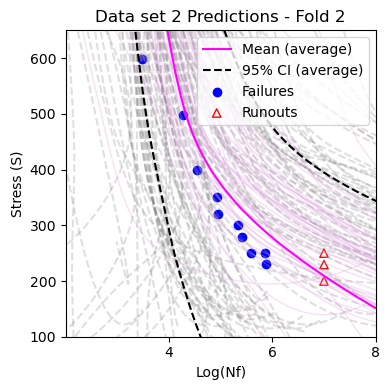

In [35]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import matplotlib.pyplot as plt
import time
import random
import os
from scipy.interpolate import make_interp_spline
from matplotlib.cm import get_cmap

# ✅ Full reproducibility setup
SEED = 20
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # Helps with determinism on CUDA >= 10.2

start = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

AM = pd.read_csv("SLM.csv")

test_complete_number = 2

Train_data = pd.read_csv("SLM_Dataset2.csv")
Test_data = pd.read_csv('SLM_TestDataset.csv')

Train_S = Train_data['Smax'].fillna(0)
Test_S = Test_data['Smax'].fillna(0)

Train_R = Train_data['Ratio'].fillna(0)
Test_R = Test_data['Ratio'].fillna(0)

Train_V = Train_data['V'].fillna(0)
Test_V = Test_data['V'].fillna(0)

Train_P = Train_data['Power'].fillna(0)
Test_P = Test_data['Power'].fillna(0)

Train_H = Train_data['Hatch'].fillna(0)
Test_H = Test_data['Hatch'].fillna(0)

Train_thick = Train_data['Thickness'].fillna(0)
Test_thick = Test_data['Thickness'].fillna(0)

Train_temp = Train_data['Temperature'].fillna(0)
Test_temp = Test_data['Temperature'].fillna(0)

Train_time = Train_data['Time'].fillna(0)
Test_time = Test_data['Time'].fillna(0)

Train_N = Train_data['N'].fillna(0)
Test_N = Test_data['N'].fillna(0)

Train_delta = Train_data['Delta'].fillna(0)
Test_delta = Test_data['Delta'].fillna(0)

Train_N_log = np.log10(Train_N)
Test_N_log = np.log10(Test_N)

def scale(train_col, test_col):
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_col.values.reshape(-1, 1))
    test_scaled = scaler.transform(test_col.values.reshape(-1, 1))
    return train_scaled, test_scaled

Train_S_scaled, Test_S_scaled = scale(Train_S, Test_S)
Train_R_scaled, Test_R_scaled = scale(Train_R, Test_R)
Train_V_scaled, Test_V_scaled = scale(Train_V, Test_V)
Train_P_scaled, Test_P_scaled = scale(Train_P, Test_P)
Train_H_scaled, Test_H_scaled = scale(Train_H, Test_H)
Train_thick_scaled, Test_thick_scaled = scale(Train_thick, Test_thick)
Train_temp_scaled, Test_temp_scaled = scale(Train_temp, Test_temp)
Train_time_scaled, Test_time_scaled = scale(Train_time, Test_time)

Train_main = torch.cat((
    torch.tensor(Train_V_scaled, dtype=torch.float32),
    torch.tensor(Train_P_scaled, dtype=torch.float32),
    torch.tensor(Train_H_scaled, dtype=torch.float32),
    torch.tensor(Train_thick_scaled, dtype=torch.float32),
    torch.tensor(Train_temp_scaled, dtype=torch.float32),
    torch.tensor(Train_time_scaled, dtype=torch.float32)
), dim=1).to(device)

Test_main = torch.cat((
    torch.tensor(Test_V_scaled, dtype=torch.float32),
    torch.tensor(Test_P_scaled, dtype=torch.float32),
    torch.tensor(Test_H_scaled, dtype=torch.float32),
    torch.tensor(Test_thick_scaled, dtype=torch.float32),
    torch.tensor(Test_temp_scaled, dtype=torch.float32),
    torch.tensor(Test_time_scaled, dtype=torch.float32)
), dim=1).to(device)

Train_data_S = torch.tensor(Train_S_scaled.reshape(-1, 1), dtype=torch.float32).to(device)
Test_data_S = torch.tensor(Test_S_scaled.reshape(-1, 1), dtype=torch.float32).to(device)

Train_data_SR = torch.tensor(Train_R_scaled.reshape(-1, 1), dtype=torch.float32).to(device)
Test_data_SR = torch.tensor(Test_R_scaled.reshape(-1, 1), dtype=torch.float32).to(device)

Train_delta_tensor = torch.tensor(Train_delta.values.reshape(-1, 1), dtype=torch.float32).to(device)
Test_delta_tensor = torch.tensor(Test_delta.values.reshape(-1, 1), dtype=torch.float32).to(device)

Train_target = torch.tensor(Train_N_log.values.reshape(-1, 1), dtype=torch.float32).to(device)
Test_target = torch.tensor(Test_N_log.values.reshape(-1, 1), dtype=torch.float32).to(device)

# === مدل و توابع مورد نیاز (مثلاً ProbabilisticNN, init_weights, negative_log_likelihood_loss) را باید از قبل تعریف کنید ===

# --- تنظیمات warmup ---
base_lr = 0.05
warmup_epochs = 10

def warmup_lr_lambda(epoch):
    if epoch < warmup_epochs:
        return 0.1 + 0.9 * (epoch / warmup_epochs)
    else:
        return 1.0

# پارامترهای ایست زودهنگام
patience = 500
min_delta = 1e-4

all_y_smooth = []
all_x_upper = []
all_x_lower = []

plt.figure(figsize=(4, 4))

for i in range(50):
    seed = 45 + i
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    model = ProbabilisticNN(num_features=6).to(device)
    

    optimizer = torch.optim.Adam(model.parameters(), lr=base_lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=warmup_lr_lambda)

    best_loss = float('inf')
    counter = 0
    best_model_state = None
    test_losses = []
    num_epochs = 1000

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        Train_data_S.requires_grad_(True)

        mean_output, std_output = model(Train_main, Train_data_S, Train_data_SR)
        loss = negative_log_likelihood_loss(Train_target, mean_output, std_output, Train_delta_tensor, Train_data_S, physics_lambda=1.0)

        loss.backward()
        optimizer.step()
        scheduler.step()

        model.constrain_sigma()
        model.constrain_mu()
        model.constrain_mu2()

        model.eval()
        with torch.no_grad():
            mean_output_test, std_output_test = model(Test_main, Test_data_S, Test_data_SR)
            test_loss = negative_log_likelihood_loss(Test_target, mean_output_test, std_output_test, Test_delta_tensor, Test_data_S, physics_lambda=0)
            test_losses.append(test_loss.item())

        if test_loss.item() + min_delta < best_loss:
            best_loss = test_loss.item()
            counter = 0
            best_model_state = model.state_dict()
        else:
            counter += 1

        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1} for seed {seed}")
            break

        if (epoch + 1) % 10 == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Seed {seed}, Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.6f}, Test Loss: {test_loss.item():.6f}, LR: {current_lr:.6f}")

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    predictions = mean_output_test.cpu().numpy().flatten()
    lower_bounds = (mean_output_test - std_output_test).cpu().numpy().flatten()
    upper_bounds = (mean_output_test + std_output_test).cpu().numpy().flatten()

    sorted_indices = np.argsort(predictions)
    x = predictions[sorted_indices]
    y = Test_S.values.flatten()[sorted_indices]
    std = (upper_bounds - lower_bounds)[sorted_indices] / 2

    x_margin = 1.1 * (x.max() - x.min())
    x_smooth = np.linspace(x.min() - x_margin, x.max() + x_margin, 300)

    x_unique, unique_indices = np.unique(x, return_index=True)
    y_unique = y[unique_indices]
    std_unique = std[unique_indices]

    spline_y = make_interp_spline(x_unique, y_unique, k=2)
    spline_std = make_interp_spline(x_unique, std_unique, k=2)

    y_smooth = spline_y(x_smooth)
    std_smooth = spline_std(x_smooth)

    x_upper = x_smooth + 1.96 * std_smooth
    x_lower = x_smooth - 1.96 * std_smooth
    y_upper = y_smooth + 1.96 * std_smooth
    y_lower = y_smooth - 1.96 * std_smooth
    y_lower_clamped = np.maximum(y_lower, 0)

    all_y_smooth.append(y_smooth)
    all_x_upper.append(x_upper)
    all_x_lower.append(x_lower)

    plt.plot(x_smooth, y_smooth, color='plum', linewidth=1,alpha=0.3)
    plt.plot(x_upper, y_smooth, '--', color='gray', alpha=0.25)
    plt.plot(x_lower, y_smooth, '--', color='gray', alpha=0.25)

mean_y_smooth = np.mean(all_y_smooth, axis=0)
mean_x_upper = np.mean(all_x_upper, axis=0)
mean_x_lower = np.mean(all_x_lower, axis=0)

plt.plot(x_smooth, mean_y_smooth, color='magenta', linewidth=1.5, label='Mean (average)')
plt.plot(mean_x_upper, mean_y_smooth, '--', color='black', linewidth=1.5, label='95% CI (average)')
plt.plot(mean_x_lower, mean_y_smooth, '--', color='black', linewidth=1.5)

delta_1_mask = Test_data['Delta'] == 1
delta_0_mask = Test_data['Delta'] == 0

plt.scatter(
    Test_target.cpu().numpy()[delta_1_mask],
    Test_data['Smax'].values[delta_1_mask],
    label='Failures', color='blue', marker='o', alpha=1
)

plt.scatter(
    Test_target.cpu().numpy()[delta_0_mask],
    Test_data['Smax'].values[delta_0_mask],
    label='Runouts', facecolors='none', edgecolors='red', marker='^', alpha=1
)

plt.xlabel('Log(Nf)')
plt.ylabel('Stress (S)')
plt.ylim(100, 650)
plt.xlim(2, 8)
plt.xticks([4, 6, 8])
plt.title(f'Data set 2 Predictions - Fold {test_complete_number}')
plt.legend()
plt.tight_layout()
plt.show()
